In [1]:
import pandas as pd
import os
import random
import chardet
import requests
import json
import numpy as np
from urllib3.util.retry import Retry
import openai
from requests.adapters import HTTPAdapter
import os
import pickle
import matplotlib.pyplot as plt
# from utils.read_group_danmu import read_group_danmu

### Load data

In [2]:
with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-FullMovies\Emotion_scores\scores_allMovies_resample.pkl', 'rb') as f:
    scores_dict = pickle.load(f)
# del scores_dict['BV1zW411d7Rb']
with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-FullMovies\Emotion_scores\times_allMovies_resample.pkl', 'rb') as f:
    time_dict= pickle.load(f)
# del time_dict['BV1zW411d7Rb']

print(len(scores_dict.keys()))
print(len(time_dict.keys()))

102
102


In [3]:
scores_all = np.zeros((0,6))
n_samples = []

scores_key = list(scores_dict.keys())
count = 0
for key in scores_key:
    print(scores_dict[key].shape)
    scores_all = np.concatenate((scores_all, scores_dict[key]), 0)
    n_samples.append(scores_dict[key].shape[0])
    count += 1
print(scores_all.shape)
n_samples_cum = np.concatenate((np.array([0]), np.cumsum(n_samples)))
print(n_samples_cum[-5:])

(4565, 6)
(3699, 6)
(4218, 6)
(1158, 6)
(3955, 6)
(3907, 6)
(4714, 6)
(3192, 6)
(2984, 6)
(3800, 6)
(3051, 6)
(3007, 6)
(4277, 6)
(5197, 6)
(3371, 6)
(3058, 6)
(3692, 6)
(3824, 6)
(3642, 6)
(3513, 6)
(6846, 6)
(2616, 6)
(2717, 6)
(3223, 6)
(3500, 6)
(4148, 6)
(3174, 6)
(3960, 6)
(3516, 6)
(3088, 6)
(4303, 6)
(2692, 6)
(4010, 6)
(2179, 6)
(2700, 6)
(4200, 6)
(3530, 6)
(3611, 6)
(3210, 6)
(4031, 6)
(3293, 6)
(4606, 6)
(5233, 6)
(3487, 6)
(4200, 6)
(3405, 6)
(4484, 6)
(3562, 6)
(3987, 6)
(4766, 6)
(3337, 6)
(2703, 6)
(2995, 6)
(2522, 6)
(4044, 6)
(3547, 6)
(3019, 6)
(2789, 6)
(1396, 6)
(3753, 6)
(3557, 6)
(4445, 6)
(5073, 6)
(3361, 6)
(3299, 6)
(3914, 6)
(2651, 6)
(2634, 6)
(3734, 6)
(3296, 6)
(5312, 6)
(4252, 6)
(2729, 6)
(2721, 6)
(3117, 6)
(2910, 6)
(4223, 6)
(2703, 6)
(3214, 6)
(3854, 6)
(3990, 6)
(3631, 6)
(3372, 6)
(2874, 6)
(3032, 6)
(2207, 6)
(3129, 6)
(2081, 6)
(2788, 6)
(2601, 6)
(4910, 6)
(3071, 6)
(1895, 6)
(4002, 6)
(4031, 6)
(3191, 6)
(2957, 6)
(3355, 6)
(2830, 6)
(3452, 6)


### PCA

Explained variance ratio: [0.49378133 0.19681466 0.16693501 0.08574263 0.03698317 0.01974321]


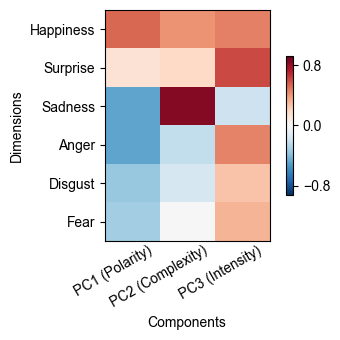

In [4]:
from sklearn.decomposition import PCA
import matplotlib
emos = ["Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear"]
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(preds_all)

pca = PCA(n_components=6)

X_pca = pca.fit_transform(scores_all)

print("Explained variance ratio:", pca.explained_variance_ratio_)

pca.components_[[3,4],:] = -pca.components_[[3,4],:]

matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(figsize=(4,3.5))
cax = ax.imshow(pca.components_.transpose()[:,:3],cmap='RdBu_r')
ax.set_aspect(0.7)
plt.xticks(np.arange(0.4,3.4,1),['PC1 (Polarity)', 'PC2 (Complexity)', 'PC3 (Intensity)'], rotation=30, ha='right')
plt.gca().tick_params(axis='x', pad=2)
plt.tick_params(axis='x', length=0)
plt.yticks(np.arange(6), emos)
plt.xlabel('Components')
plt.ylabel('Dimensions')
cbar = plt.colorbar(cax, shrink=0.6)
cbar.set_ticks([-0.8, 0.0, 0.8])
# max_lim = np.maximum(np.nanmax(pca.components_), -np.nanmin(pca.components_))
cax.set_clim([-0.921, 0.921])
# print(max_lim)
plt.tight_layout()
plt.savefig('figures/pca_scores_danmu_all_PC3.svg', dpi=300, bbox_inches='tight')
plt.show()

In [5]:
from copy import deepcopy
with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Emotion_scores\scores_longMovie_gpt3_5_turbo.pkl', 'rb') as f:
    preds = pickle.load(f)

In [6]:
from copy import deepcopy
with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Emotion_scores\scores_longMovie_gpt3_5_turbo.pkl', 'rb') as f:
    preds = pickle.load(f)
preds = preds['forrest_gump']
# preds = np.load('scores_longMovie_deepseek.npy')

with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Processed_danmu\danmu_Forrest_Gump_downsample.pkl', 'rb') as f:
    danmu_dict = pickle.load(f)
print(danmu_dict.keys())
time_ranges = danmu_dict['forrest_gump.csv_time_range']

# cut predicted scores and time_points_german into 8 runs
cut_index2 = [[0, 22550/25], [22150/25, 32312/25], [36349/25, 48237/25], [47837/25, 57798/25], [58470/25, 70409/25], [70009/25, 85997/25], [89293/25, 97705/25], [97305/25, 117351/25], [120616/25, 123670/25], [123270/25, 141457/25], [145869/25, 149632/25], [149232/25, 152260/25], [154244/25, 178316/25],  [177916/25, 194792/25]]
time_points = np.zeros(len(time_ranges))
for i in range(len(time_points)):
    time_points[i] = np.mean(time_ranges[i])
# Find time points in the original movie (time points are for bilibili version, which cut 4 segments)

time_points_ori = deepcopy(time_points)
time_points_ori[time_points_ori>=4443] = time_points_ori[time_points_ori>=4443] + (4462-4443)
time_points_ori[time_points_ori>=4483] = time_points_ori[time_points_ori>=4483] + (4514-4483)
time_points_ori[time_points_ori>=5177] = time_points_ori[time_points_ori>=5177] + (5210-5177)
time_points_ori[time_points_ori>=5371] = time_points_ori[time_points_ori>=5371] + (5380-5371)

# Find time points in the german version. (the frame rate was different from the original movie)
time_points_german = time_points_ori / (25/(24000/1001))

preds_cut = np.zeros((0,6))
time_points_german_cut = np.zeros(0)
for i in range(len(cut_index2)):
    preds_cut = np.concatenate((preds_cut, preds[(time_points_german >= cut_index2[i][0]) & (time_points_german <= cut_index2[i][1]), :]), 0)
    time_points_german_cut = np.concatenate((time_points_german_cut, time_points_german[(time_points_german >= cut_index2[i][0]) & (time_points_german <= cut_index2[i][1])]), 0)

# Get time of ratings in German version
time_ratings = []
seg_lens = [902,882,876,976,924,878,1084,676]
for i in range(8):
    tmp = np.arange(0,seg_lens[i],2)
    if (i > 0) and (i < 7): # The first and the last runs only have one segment
        tmp = tmp + cut_index2[i*2-1][0]
        tmp[tmp > cut_index2[i*2-1][1]]  = tmp[tmp > cut_index2[i*2-1][1]] + cut_index2[i*2][0] - cut_index2[i*2-1][1] # Add skipped time
    elif i == 7:
        tmp = tmp + cut_index2[i*2-1][0]
    time_ratings.extend(tmp)
    
# Resample preds_cut to the same sampling rate of ratings_mean (by average over 2s neighboring to time_ratings)
preds_cut_resample = np.zeros((3599, 6))
for i in range(3599):
    if np.sum((time_points_german_cut < (time_ratings[i]+1)) & (time_points_german_cut >= (time_ratings[i]-1)))==0:
        preds_cut_resample[i,:] = preds_cut_resample[i-1,:]
    else:
        preds_cut_resample[i,:] = np.mean(preds_cut[(time_points_german_cut < (time_ratings[i]+1)) & (time_points_german_cut >= (time_ratings[i]-1)),:], axis=0)

# Smooth the predicted scores over ts windows
smooth_win = 10
preds_smoothed = np.zeros(preds_cut_resample.shape)
for i in range(preds_cut_resample.shape[0]):
    tmp = preds_cut_resample[abs(time_ratings - time_ratings[i]) <= smooth_win//2, :]
    preds_smoothed[i,:] = np.mean(tmp[np.sum(np.abs(tmp), axis=1)!=0, :], axis=0)

dict_keys(['forrest_gump.csv', 'forrest_gump.csv_time_range'])


In [7]:
from scipy import stats
import h5py
# load ratings
path=r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\Lettieri-Forrest\forrest_gump_movie_italian\raw_ratings.mat'
ratings_all=np.zeros([12,6,3599])
count = 0
with h5py.File(path,'r') as file:
    for item in file.items():
        # print(item[0])
        tmp = file[item[0]][:][[0,1,3,4,5,2],:] # reorder to [高兴、惊讶、悲伤、愤怒、厌恶、恐惧]
        ratings_all[count]=tmp
        count += 1
ratings_mean = np.mean(ratings_all, axis=0)
ratings_mean = ratings_mean.transpose()

ratings_smoothed = np.zeros(preds_cut_resample.shape)
for i in range(ratings_smoothed.shape[0]):
    tmp = ratings_mean[abs(time_ratings - time_ratings[i]) <= smooth_win//2, :]
    ratings_smoothed[i,:] = np.mean(tmp, axis=0)

Explained variance ratio: [0.54792509 0.22046489 0.1281383  0.06499654 0.02649904 0.01197614]


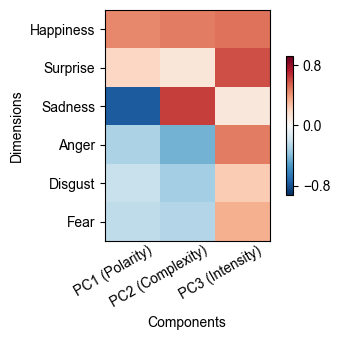

Explained variance ratio: [0.45866067 0.23605802 0.1594916  0.0765148  0.05582819 0.01344671]


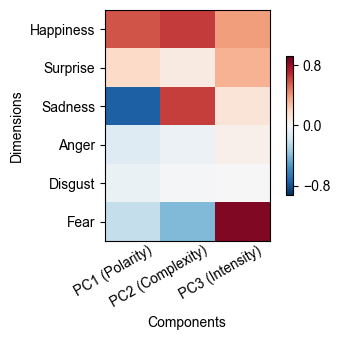

In [8]:
from sklearn.decomposition import PCA
import matplotlib
emos = ["Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear"]
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(preds_all)

# 创建PCA对象，设定要保留的主成分数量（例如：2个主成分）
pca = PCA(n_components=6)

# 使用PCA降维
X_pca = pca.fit_transform(preds_smoothed)

# 解释方差比例（每个主成分解释的方差占总方差的比例）
print("Explained variance ratio:", pca.explained_variance_ratio_)

pca.components_[[0,3,4],:] = -pca.components_[[0,3,4],:]

matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(figsize=(4,3.5))
cax = ax.imshow(pca.components_.transpose()[:,:3],cmap='RdBu_r')
ax.set_aspect(0.7)
plt.xticks(np.arange(0.4,3.4,1),['PC1 (Polarity)', 'PC2 (Complexity)', 'PC3 (Intensity)'], rotation=30, ha='right')
plt.gca().tick_params(axis='x', pad=2)
plt.tick_params(axis='x', length=0)
plt.yticks(np.arange(6), emos)
plt.xlabel('Components')
plt.ylabel('Dimensions')
cbar = plt.colorbar(cax, shrink=0.6)
cbar.set_ticks([-0.8, 0.0, 0.8])
# max_lim = np.maximum(np.nanmax(pca.components_), -np.nanmin(pca.components_))
cax.set_clim([-0.921, 0.921])
# print(max_lim)
plt.tight_layout()
plt.savefig('figures/pca_scores_danmu_forrest_gump_PC3.svg', dpi=300, bbox_inches='tight')
plt.show()


pca = PCA(n_components=6)

# 使用PCA降维
X_pca = pca.fit_transform(ratings_smoothed)

# 解释方差比例（每个主成分解释的方差占总方差的比例）
print("Explained variance ratio:", pca.explained_variance_ratio_)

pca.components_[[0,3,4],:] = -pca.components_[[0,3,4],:]

matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(figsize=(4,3.5))
cax = ax.imshow(pca.components_.transpose()[:,:3],cmap='RdBu_r')
ax.set_aspect(0.7)
plt.xticks(np.arange(0.4,3.4,1),['PC1 (Polarity)', 'PC2 (Complexity)', 'PC3 (Intensity)'], rotation=30, ha='right')
plt.gca().tick_params(axis='x', pad=2)
plt.tick_params(axis='x', length=0)
plt.yticks(np.arange(6), emos)
plt.xlabel('Components')
plt.ylabel('Dimensions')
cbar = plt.colorbar(cax, shrink=0.6)
cbar.set_ticks([-0.8, 0.0, 0.8])
# max_lim = np.maximum(np.nanmax(pca.components_), -np.nanmin(pca.components_))
cax.set_clim([-0.921, 0.921])
# print(max_lim)
plt.tight_layout()
plt.savefig('figures/pca_scores_ratings_forrest_gump_PC3.svg', dpi=300, bbox_inches='tight')
plt.show()

### Emotion dynamic space

In [9]:
import os, json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.patches import Circle, FancyArrowPatch
from scipy.ndimage import gaussian_filter
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity

def _scott_bandwidth(X2):
    X2 = np.asarray(X2, float); n, d = X2.shape
    s = X2.std(axis=0, ddof=1).mean()
    return s * n ** (-1.0 / (d + 4))

def _hdr_thresholds(dens_grid, levels=(0.5, 0.8, 0.95), cell_area=1.0):
    f = dens_grid.ravel()
    idx = np.argsort(f)[::-1]
    mass = np.cumsum(f[idx]) * cell_area
    total = mass[-1]
    thr = []
    for a in levels:
        k = np.searchsorted(mass, a*total)
        k = min(max(k, 0), len(f)-1)
        thr.append(float(f[idx[k]]))
    return sorted(thr)

def _kde_on_grid(X2, xs, ys, bandwidth):
    XX, YY = np.meshgrid(xs, ys)
    grid = np.c_[XX.ravel(), YY.ravel()]
    kde = KernelDensity(kernel="gaussian", bandwidth=bandwidth)
    kde.fit(X2)
    logd = kde.score_samples(grid)
    dens = np.exp(logd).reshape(XX.shape)
    return XX, YY, dens

def _global_assign_and_transition(scores_all, centers6, n_samples_cum, eps=1e-6):
    X = np.asarray(scores_all, float)
    dif = X[:, None, :] - centers6[None, :, :]
    d2 = np.sum(dif*dif, axis=2)
    labels = d2.argmin(axis=1).astype(int)  # 0..5

    K = 6
    C = np.zeros((K, K), float)
    M = len(n_samples_cum) - 1
    for m in range(M):
        s, e = int(n_samples_cum[m]), int(n_samples_cum[m+1])
        if e - s <= 1: continue
        seg = labels[s:e]
        for a, b in zip(seg[:-1], seg[1:]):
            C[a, b] += 1.0
    P = C + eps
    P = P / P.sum(axis=1, keepdims=True)
    pi = (P.sum(axis=0) + eps)
    pi = pi / pi.sum()
    return labels, P, pi

def fit_six_emotion_anchors(
    scores_all, topk_frac=0.20, eps=1e-6
):

    X = np.asarray(scores_all, float)
    N, D = X.shape
    assert D == 6

    sums = X.sum(axis=1, keepdims=True) + eps
    purity = X / sums  
    centers = np.zeros((6, D), float)
    covs = np.zeros((6, D, D), float)
    counts = np.zeros(6, int)

    for k in range(6):
        mask = (X.argmax(axis=1) == k)
        Xk = X[mask]
        # if len(Xk) < min_n:
        #     idx = np.argsort(purity[:, k])[::-1]
        #     take = max(min_n, int(topk_frac * N))
        #     Xk = X[idx[:take]]

        m = len(Xk)
        # print(int(topk_frac * m))
        kk = int(topk_frac * m)
        idx2 = np.argsort(Xk[:, k])[::-1][:kk]
        Xk2 = Xk[idx2]

        centers[k] = Xk2.mean(axis=0)
        C = np.cov(Xk2, rowvar=False)
        C = 0.5*(C + C.T) + 1e-9*np.eye(D)
        covs[k] = C
        counts[k] = len(Xk2)
    return centers, covs, counts

EMO_NAMES  = ["Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear"]
EMO_COLORS = ['#d62728', '#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b']

In [10]:
centers6, covs6, counts = fit_six_emotion_anchors(
    scores_all,        # (N, 6)
    # purity_tau=1.0,   
    topk_frac=0.50 
    # min_n=500         
)
print("anchors per emotion:", counts)

anchors per emotion: [112913  37849  12221  13095    787   1218]


In [11]:
random_state = 0
grid_res=400
bandwidth=None
bandwidth_scale=1.0
glow_sigma=6.0
levels=(0.5, 0.8, 0.95, 0.99)
    
rng = np.random.default_rng(random_state)

# 1) PCA(2) on pooled data
pca = PCA(n_components=2, svd_solver="full", random_state=random_state)
X2 = pca.fit_transform(scores_all)
C2 = pca.transform(centers6)  

# 3) KDE on a shared grid
pad = 0.01
xmin, xmax = X2[:,0].min(), X2[:,0].max()
ymin, ymax = X2[:,1].min(), X2[:,1].max()
dx, dy = xmax - xmin, ymax - ymin
xmin -= pad*dx; xmax = xmax+pad*dx+0.06; ymin -= pad*dy; ymax += pad*dy

xs = np.linspace(xmin, xmax, grid_res)
ys = np.linspace(ymin, ymax, grid_res)
cell_area = (xs[1]-xs[0]) * (ys[1]-ys[0])

if bandwidth is None:
    bandwidth = _scott_bandwidth(X2) * float(bandwidth_scale)

# XX, YY, dens = _kde_on_grid(X2, xs, ys, bandwidth)
# dens_blur = gaussian_filter(dens, sigma=glow_sigma)
# thr = _hdr_thresholds(dens, levels=levels, cell_area=cell_area)


In [12]:
with open('kde_prep2.pkl', 'rb') as f:
    kde_prep = pickle.load(f)
XX, YY, dens, dens_blur, thr = kde_prep['XX'], kde_prep['YY'], kde_prep['dens'], kde_prep['dens_blur'], kde_prep['thr']

In [13]:
print(xmin, xmax, ymin, ymax)
print(np.min(XX), np.max(XX), np.min(YY), np.max(YY))
xmin, xmax, ymin, ymax = np.min(XX), np.max(XX), np.min(YY), np.max(YY)

-9.375047871028144 4.643644358322811 -5.303414152688677 6.301404531999867
-10.059297490113975 5.267893977408642 -5.872277813702821 6.870268193014011


In [14]:
traj_lines = []
for i in range(102):
    seg = X2[n_samples_cum[i]: n_samples_cum[i+1]]
    traj_lines.append(seg)

In [15]:
levels=(0.5, 0.8, 0.95, 0.999)
thr = _hdr_thresholds(dens, levels=levels, cell_area=cell_area)

In [16]:
from matplotlib.colors import LinearSegmentedColormap
EMO_COLORS = ['#d62728', '#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b']
EMO_COLORS_WHITE_BG = EMO_COLORS

C:\Users\Windows\AppData\Local\Temp\ipykernel_18892\4203426774.py:42: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for c in cs.collections:


[Peak cell] iy=166, ix=277, coord=(0.5814, -0.5709)


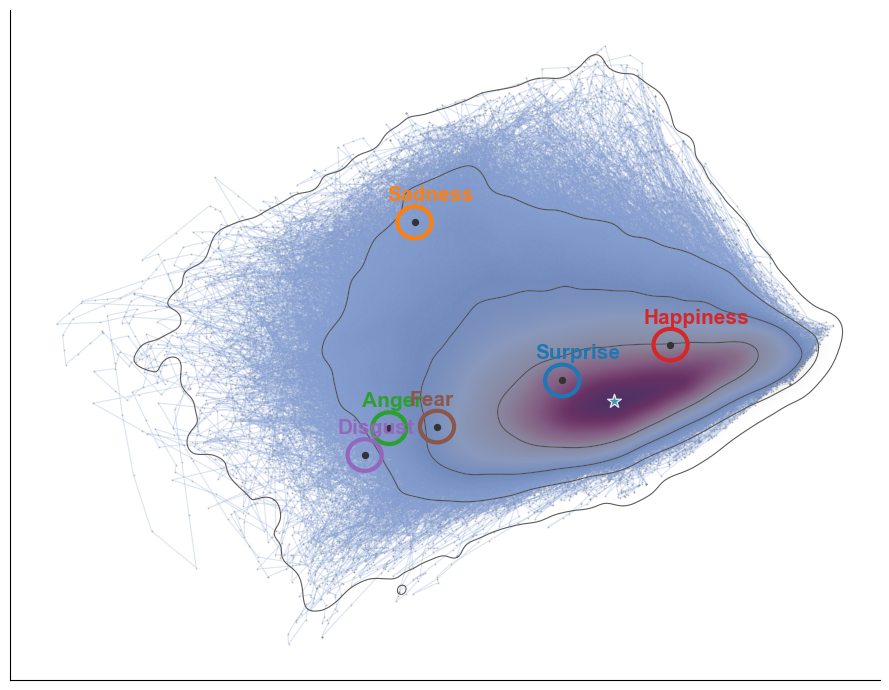

In [17]:
out_path_jpg='figures/emotion_dynamic_space2_noword.svg'
traj_alpha=0.3

fig = plt.figure(figsize=(9, 7), facecolor="white")
ax = plt.gca()
ax.set_facecolor("white")

D = np.log1p(dens)          # log

vmin = np.min(D)
vmax = np.max(D)

# 使用OrRd色系，从白色开始
colors = ['white', "#CCCBC9", '#FEE8C8', '#FDD49E', '#FDBB84', '#FC8D59', '#EF6548', '#D7301F', '#B30000', '#7F0000']
cmap = LinearSegmentedColormap.from_list('white_OrRd', colors)

# 或者更简单的版本，只使用几个关键颜色
# colors = ['white', '#FEE8C8', '#FDBB84', '#FC8D59', '#EF6548', '#D7301F', '#B30000']
# cmap = LinearSegmentedColormap.from_list('white_OrRd_simple', colors)

idx = np.arange(len(X2))
ax.scatter(X2[idx,0], X2[idx,1],
           s=2.5, c="#333333", alpha=0.2,
           linewidths=0, zorder=0, rasterized=True)

ax.scatter(X2[idx,0], X2[idx,1],
           s=1, c="#1A1A1A", alpha=0.4,
           linewidths=0, zorder=1, rasterized=True)

for seg in traj_lines:
    ax.plot(seg[:,0], seg[:,1], lw=0.8, alpha=traj_alpha, color="#2E5CB8")
    
im = ax.imshow(
    D, extent=(xmin, xmax, ymin, ymax), origin="lower",
    cmap=cmap, vmin=vmin, vmax=vmax,
    alpha=0.45, interpolation="bilinear", aspect="auto", zorder=2
)

# 改为深色等高线
for t in thr:
    cs = ax.contour(XX, YY, dens, levels=[t], colors="#333333", linewidths=0.8, alpha=0.8)
    for c in cs.collections:
        c.set_path_effects([pe.Stroke(linewidth=0.6, foreground="#FFFFFF88"), pe.Normal()])

center_mass = X2.mean(axis=0)
# 定义在白色背景下可见的情绪颜色
# EMO_COLORS_WHITE_BG = ['#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00', '#FFFF33']

for k, (cx, cy) in enumerate(C2):
    ring = Circle((cx, cy), radius=0.22*max(dx,dy)/10,
                    facecolor='none', edgecolor=EMO_COLORS_WHITE_BG[k], linewidth=3.0, zorder=3)
    ax.add_patch(ring)
    ax.scatter([cx], [cy], s=18, color="#333333", zorder=4)
    #v = np.array([cx, cy]) - center_mass
    #v = v / (np.linalg.norm(v) + 1e-9)
    lx, ly = cx-0.035*dx, cy + 0.035*dy#*v[1]
    txt = ax.text(lx, ly, EMO_NAMES[k],
                    color=EMO_COLORS_WHITE_BG[k], fontsize=15, weight="bold", zorder=5)
    # txt.set_path_effects([pe.Stroke(linewidth=1.1, foreground="#FFFFFFCC"), pe.Normal()])

ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
ax.set_xticks([]); ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 寻找 dens 的全局最大栅格索引（注意：dens.shape = (ny, nx)）
iy, ix = np.unravel_index(np.argmax(dens), dens.shape)   # 行(y)、列(x)索引
x_peak, y_peak = XX[iy, ix], YY[iy, ix]                  # 映射到坐标系
print(f"[Peak cell] iy={iy}, ix={ix}, coord=({x_peak:.4f}, {y_peak:.4f})")

# 在图上标注峰值（小圆环+星标）
peak_color = '#3B9AB2'  # 亮青蓝色，与红橙色系形成强对比

ax.scatter([x_peak], [y_peak],
           s=108, marker='*',
           color=peak_color,
           edgecolor='#FFFFFFDD', linewidth=0.9, zorder=6)
# ax.scatter([x_peak], [y_peak], s=58, marker='*', color='white',
#            edgecolor='#000000AA', linewidth=1.5, zorder=6)

# cbar = plt.colorbar(im, ax=ax, fraction=0.04, pad=0.02, shrink=0.3)
# cbar.set_label("Density", color="black")
# cbar.ax.yaxis.set_tick_params(color="black")
# plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='black')
# ax.set_aspect('equal')
plt.tight_layout()
# plt.savefig(out_path_jpg, dpi=300, bbox_inches='tight')

In [23]:
movie_names_eng = [
    "Batman Dark Knight",
    "Be Somebody",
    "Forrest Gump",
    "Big World Gashapon",
    "Godzilla",
    "Green Book",
    "Harry Potter and the Goblet of Fire",
    "Heidi",
    "Kung Fu",
    "Let the Bullets Fly",
    "The Legend of Luo Xiaohei",
    "The Bad Guys",
    "The Shawshank Redemption",
    "The Wandering Earth II",
    "Weathering With You",
    "White Snake",
    "World War Z",
    "Yang Jian",
    "Suzume",  # 铃芽之旅
    "Johnny Keep Walking!",  # 年会不能停!
    "The Lord of the Rings: The Fellowship of the Ring",  # 指环王1
    "The SpongeBob SquarePants Movie",  # 海绵宝宝历险记
    "Our Fathers",  # 我们的父辈
    "Detective Conan: The Phantom of Baker Street",  # 名侦探柯南
    "Love Letter",  # 情书
    "Harry Potter and the Order of the Phoenix",
    "Detective Conan: The Bride of Halloween",
    "White Snake 2: The Tribulation of Green Snake",
    "New Gods: Nezha Reborn",
    "The Truman Show",  # 楚门的世界
    "Transformers",
    "Flipped",  # 怦然心动
    "The Pig, the Snake and the Pigeon",  # 周处除三害
    "Date A Live Movie: Mayuri Judgment",
    "Rascal Does Not Dream of a Dreaming Girl",
    "Violet Evergarden: The Movie",
    "Journey to the West",  # 宇宙探索编辑部
    "Sword Art Online: Ordinal Scale",  # 刀剑神域
    "Overlord: The Dark Hero",
    "Rurouni Kenshin",  # 浪客剑心
    "A Silent Voice",  # 声之形
    "Harry Potter and the Half-Blood Prince",
    "Harry Potter and the Chamber of Secrets",
    "Still Miss You",  # 还是觉得你最好
    "Ready Player One",  # 头号玩家
    "Edge of Tomorrow",  # 明日边缘
    "Transformers: Revenge of the Fallen",
    "Fate/stay night: Heaven's Feel I. presage flower",
    "Fantastic Beasts and Where to Find Them",
    "Harry Potter and the Sorcerer's Stone",
    "Promare",  # 普罗米亚
    "Fireworks",  # 烟花
    "Goodbye Mr. Loser",  # 夏洛特烦恼
    "Tamako Love Story",  # 玉子爱情故事
    "Leap",  # 夺冠
    "A Little Thing Called Love",  # 初恋这件小事
    "The Legend of Sealed Book",  # 天书奇谭
    "The SpongeBob Movie: Sponge Out of Water",  # 海绵宝宝水兵陆战队
    "The Garden of Words",  # 言叶之庭
    "Kowloon Walled City",  # 九龙城寨
    "The Silence of the Lambs",
    "Inception",  # 盗梦空间
    "Interstellar",
    "Deep Sea",  # 深海
    "Jiang Ziya",  # 姜子牙
    "Harry Potter and the Deathly Hallows Part 2",
    "CJ7",  # 长江七号
    "Lost on Journey",  # 人在囧途
    "Only Fools Rush In",  # 四海
    "Five Hundred Miles",  # 交换人生
    "The Godfather",
    "Harry Potter and the Prisoner of Azkaban",
    "Minions",  # 小黄人大眼萌
    "Violet Evergarden: Eternity and the Auto Memories Doll",
    "One Second",  # 一秒钟
    "Sword Art Online Progressive: Aria of a Starless Night",
    "Catch Me If You Can",  # 猫鼠游戏
    "Wolf Warrior",  # 战狼
    "Brotherhood of Blades",  # 绣春刀
    "Hidden Blade",  # 无名
    "Endless Journey",  # 三大队
    "Pegasus 2",  # 飞驰人生2
    "Evangelion: 2.22 You Can (Not) Advance",
    "Evangelion: 3.33 You Can (Not) Redo",
    "Evangelion: 1.11 You Are (Not) Alone",
    "Evangelion: Death and Rebirth",
    "Crazy Racer",  # 疯狂的赛车
    "My Little Pony Equestria Girls: Friendship Games",  # 彩虹小马
    "My Own Swordsman",  # 武林外传
    "Words Bubble Up Like Soda Pop",  # 言语如苏打般涌现
    "No Time to Die",  # 007
    "Overlord: The Undead King",
    "5 Centimeters Per Second",  # 秒速5厘米
    "Win the Kids",  # 抓娃娃
    "The Founding of a Republic",  # 建国大业
    "Ip Man",  # 叶问
    "The King's Avatar: For the Glory",  # 全职高手
    "Shin Ultraman",  # 新·奥特曼
    "Pleasant Goat and Big Big Wolf: Dunk for Future",  # 喜羊羊
    "One Piece Film: Red",  # 航海王
    "Johnny English",  # 憨豆特工
    "Pacific Rim"  # 环太平洋
]

In [24]:
sel_movies = ['Forrest Gump', 'World War Z', 'Godzilla', 'The Bad Guys', 'The Godfather', 'White Snake']
use_inds = []
for i in range(6):
    use_inds.append(movie_names_eng.index(sel_movies[i]))
print(use_inds)

[2, 16, 4, 11, 70, 15]


Forrest Gump
anchors per emotion: [1462  181  392   60    2   11]


C:\Users\Windows\AppData\Local\Temp\ipykernel_10020\1452983038.py:80: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for c in cs.collections:


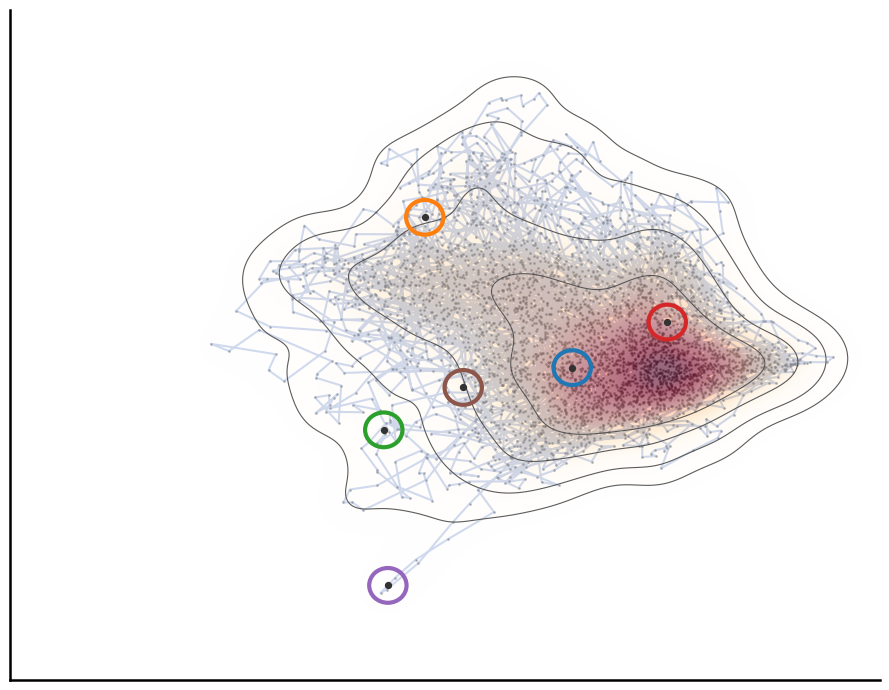

World War Z
anchors per emotion: [590 924  17 216   4  93]


C:\Users\Windows\AppData\Local\Temp\ipykernel_10020\1452983038.py:80: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for c in cs.collections:


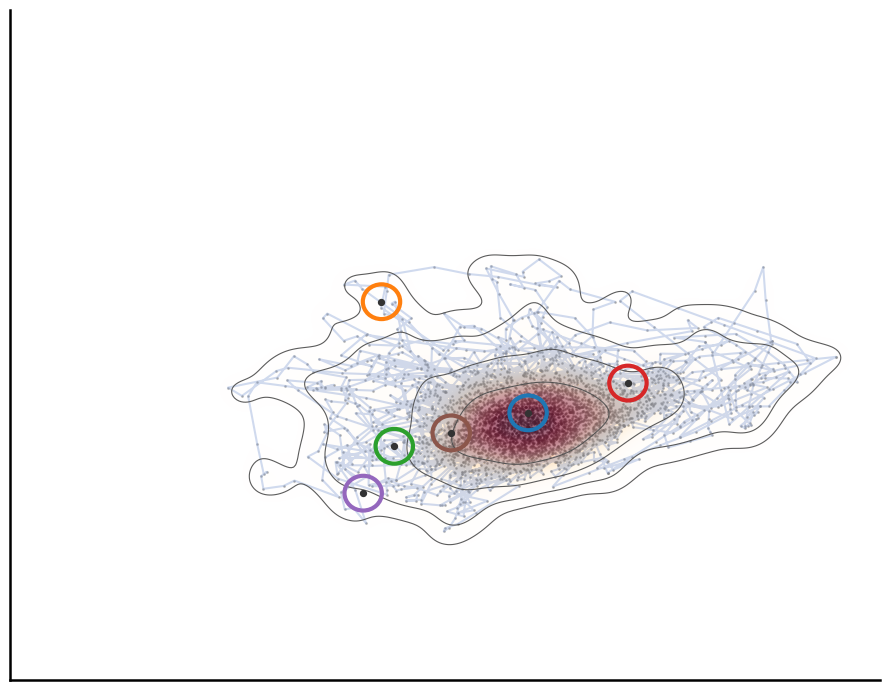

Godzilla
anchors per emotion: [709 898  18 352   0   0]
Removed 2 invalid emotion centers


C:\Users\Windows\AppData\Local\Temp\ipykernel_10020\478465052.py:85: RuntimeWarning: Mean of empty slice.
  centers[k] = Xk2.mean(axis=0)
c:\Users\Windows\anaconda3\envs\cl_sster_env\envs\llm_openai\Lib\site-packages\numpy\_core\_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\Windows\anaconda3\envs\cl_sster_env\envs\llm_openai\Lib\site-packages\numpy\lib\_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\Windows\AppData\Local\Temp\ipykernel_10020\478465052.py:86: RuntimeWarning: Degrees of freedom <= 0 for slice
  C = np.cov(Xk2, rowvar=False)
c:\Users\Windows\anaconda3\envs\cl_sster_env\envs\llm_openai\Lib\site-packages\numpy\lib\_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\Windows\anaconda3\envs\cl_sster_env\envs\llm_openai\Lib\site-packages\numpy\lib\_function_base_impl.py:2894: RuntimeWarning: i

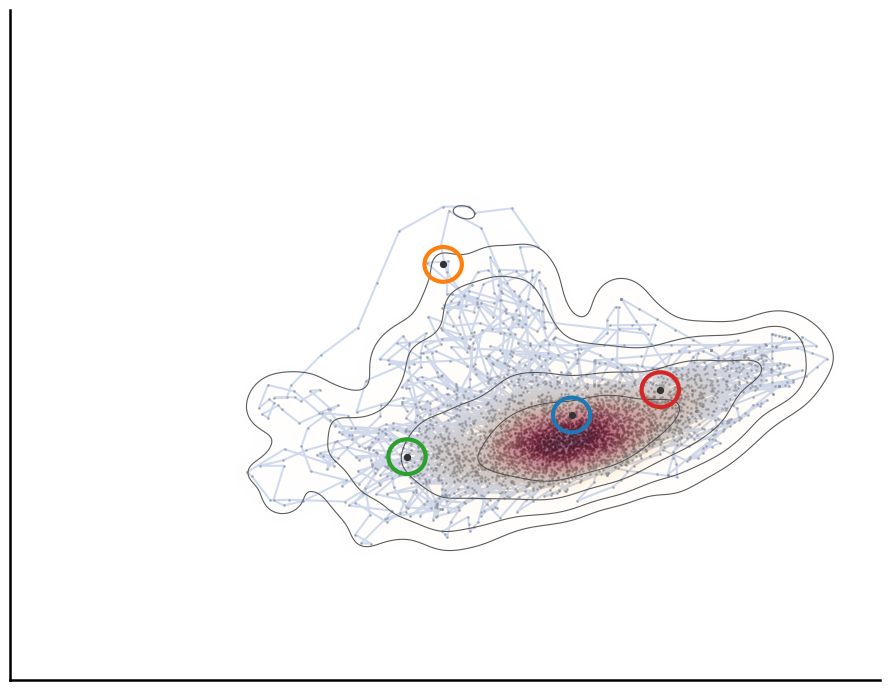

The Bad Guys
anchors per emotion: [1287  179   14   22    0    0]
Removed 2 invalid emotion centers


C:\Users\Windows\AppData\Local\Temp\ipykernel_10020\478465052.py:85: RuntimeWarning: Mean of empty slice.
  centers[k] = Xk2.mean(axis=0)
c:\Users\Windows\anaconda3\envs\cl_sster_env\envs\llm_openai\Lib\site-packages\numpy\_core\_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\Windows\anaconda3\envs\cl_sster_env\envs\llm_openai\Lib\site-packages\numpy\lib\_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\Windows\AppData\Local\Temp\ipykernel_10020\478465052.py:86: RuntimeWarning: Degrees of freedom <= 0 for slice
  C = np.cov(Xk2, rowvar=False)
c:\Users\Windows\anaconda3\envs\cl_sster_env\envs\llm_openai\Lib\site-packages\numpy\lib\_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\Windows\anaconda3\envs\cl_sster_env\envs\llm_openai\Lib\site-packages\numpy\lib\_function_base_impl.py:2894: RuntimeWarning: i

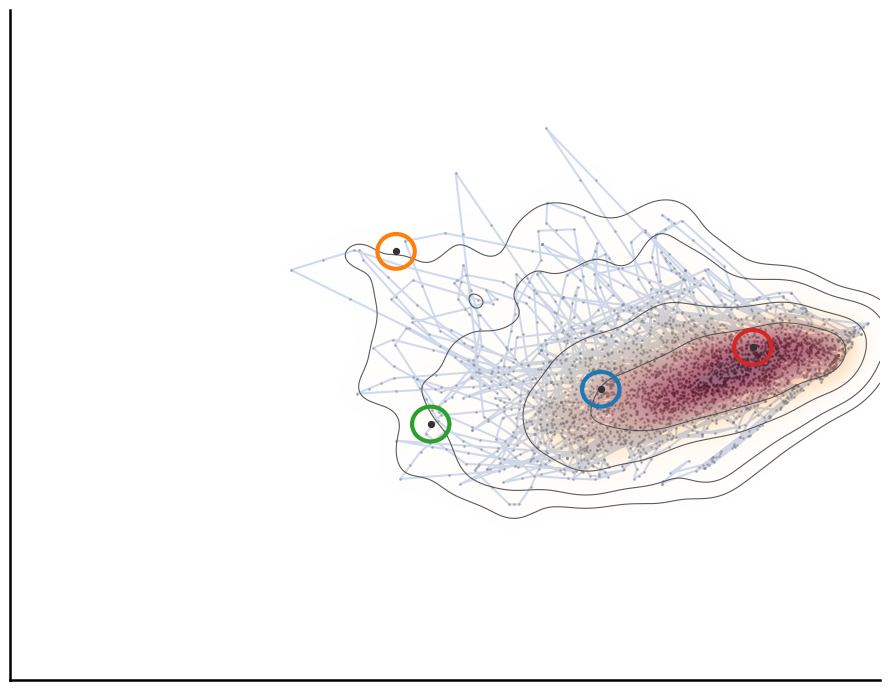

The Godfather
anchors per emotion: [1425  556  172  461    8   33]


C:\Users\Windows\AppData\Local\Temp\ipykernel_10020\1452983038.py:80: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for c in cs.collections:


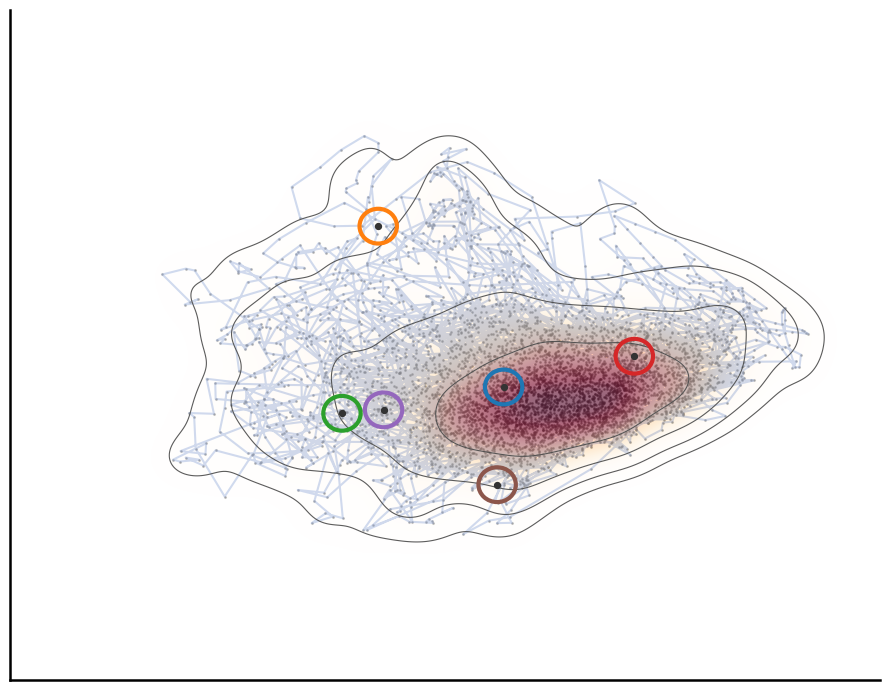

White Snake
anchors per emotion: [1145  157  128   87    3    7]


C:\Users\Windows\AppData\Local\Temp\ipykernel_10020\1452983038.py:80: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for c in cs.collections:


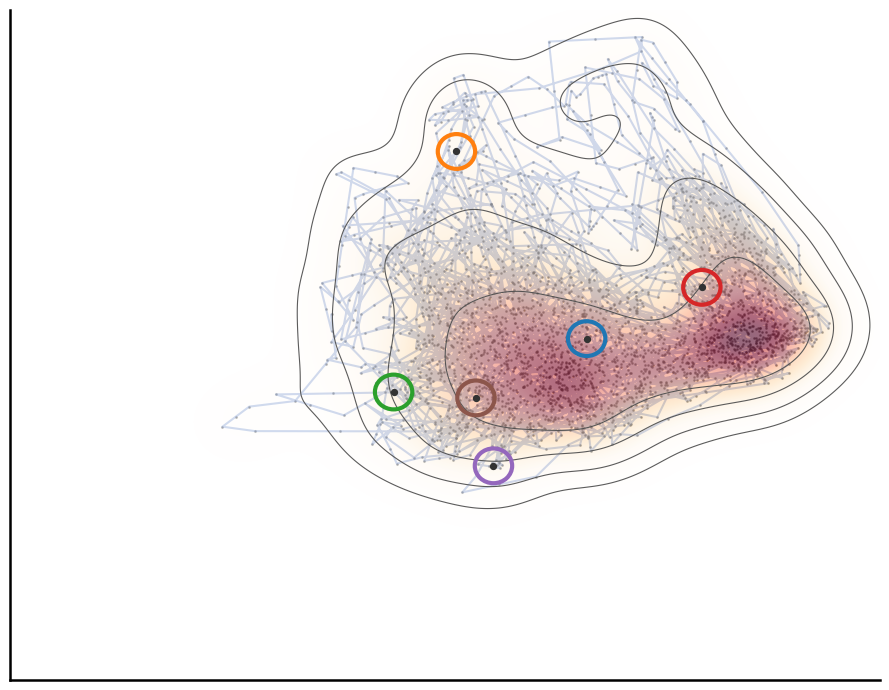

In [25]:
for i in use_inds:
    print(movie_names_eng[i])
    scores_now = scores_all[n_samples_cum[i]: n_samples_cum[i+1]]
    centers6, covs6, counts = fit_six_emotion_anchors(
        scores_now,        # (N, 6)
        topk_frac=0.50
        )
    print("anchors per emotion:", counts)
    
    nan_mask = np.isnan(centers6).any(axis=1)
    if nan_mask.any():
        print(f"Warning: Found NaN values in centers6 for emotion indices: {np.where(nan_mask)[0]}")
        valid_indices = ~nan_mask
        centers6 = centers6[valid_indices]
        covs6 = covs6[valid_indices]
        counts = counts[valid_indices]
        print(f"Removed {nan_mask.sum()} invalid emotion centers")

    random_state = 0
    grid_res=400
    bandwidth=None
    bandwidth_scale=1.0
    glow_sigma=6.0
    levels=(0.5, 0.8, 0.95, 0.99)
        
    rng = np.random.default_rng(random_state)

    # 1) PCA(2) on pooled data
    # pca = PCA(n_components=2, svd_solver="full", random_state=random_state)
    X2 = pca.transform(scores_now)
    C2 = pca.transform(centers6)  

    # 3) KDE on a shared grid
    pad = 0.06
    xs = np.linspace(xmin, xmax, grid_res)
    ys = np.linspace(ymin, ymax, grid_res)
    cell_area = (xs[1]-xs[0]) * (ys[1]-ys[0])

    if bandwidth is None:
        bandwidth = _scott_bandwidth(X2) * float(bandwidth_scale)

    XX, YY, dens = _kde_on_grid(X2, xs, ys, bandwidth)
    dens_blur = gaussian_filter(dens, sigma=glow_sigma)
    thr = _hdr_thresholds(dens, levels=levels, cell_area=cell_area)

    # out_path_jpg='figures/emotion_dynamic_space.svg'
    traj_alpha=0.4

    fig = plt.figure(figsize=(9, 7), facecolor="white")
    ax = plt.gca()
    ax.set_facecolor("white")

    D = np.log1p(dens)          # log

    vmin = np.min(D)
    vmax = np.max(D)

    colors = ['white', '#FFF7EC', '#FEE8C8', '#FDD49E', '#FDBB84', '#FC8D59', '#EF6548', '#D7301F', '#B30000', '#7F0000']
    cmap = LinearSegmentedColormap.from_list('white_OrRd', colors)

    idx = np.arange(len(X2))
    ax.scatter(X2[idx,0], X2[idx,1],
            s=5, c="#333333", alpha=0.3,
            linewidths=0, zorder=0, rasterized=True)

    ax.scatter(X2[idx,0], X2[idx,1],
            s=2, c="#1A1A1A", alpha=0.6,
            linewidths=0, zorder=1, rasterized=True)

    ax.plot(X2[:,0], X2[:,1], lw=1.5, alpha=traj_alpha, color="#2E5CB8")
        
    im = ax.imshow(
        D, extent=(xmin, xmax, ymin, ymax), origin="lower",
        cmap=cmap, vmin=vmin, vmax=vmax,
        alpha=0.45, interpolation="bilinear", aspect="auto", zorder=2
    )

    for t in thr:
        cs = ax.contour(XX, YY, dens, levels=[t], colors="#333333", linewidths=0.8, alpha=0.8)
        for c in cs.collections:
            c.set_path_effects([pe.Stroke(linewidth=0.6, foreground="#FFFFFF88"), pe.Normal()])

    center_mass = X2.mean(axis=0)
    for k, (cx, cy) in enumerate(C2):
        if np.isnan(cx) or np.isnan(cy):
            print(f"Skipping emotion center {k} due to NaN values")
            continue
            
        ring = Circle((cx, cy), radius=0.22*max(dx,dy)/10,
                        facecolor='none', edgecolor=EMO_COLORS_WHITE_BG[k], linewidth=3.0, zorder=3)
        ax.add_patch(ring)
        ax.scatter([cx], [cy], s=18, color="#333333", zorder=4)
        v = np.array([cx, cy]) - center_mass
        v = v / (np.linalg.norm(v) + 1e-9)
        lx, ly = cx + 0.02*dx*v[0], cy + 0.04*dy*v[1]

    ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
    ax.set_xticks([]); ax.set_yticks([])
    # ax.set_aspect('equal')
    ax.spines['bottom'].set_linewidth(1.8)
    ax.spines['left'].set_linewidth(1.8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.savefig('figures/dynamic_space_%s.svg' % scores_key[i], bbox_inches='tight', dpi=300)
    plt.show()

### Six clusters

In [34]:
movie_names_eng = [
    "Batman Dark Knight",
    "Be Somebody",
    "Forrest Gump",
    "Big World Gashapon",
    "Godzilla",
    "Green Book",
    "Harry Potter and the Goblet of Fire",
    "Heidi",
    "Kung Fu",
    "Let the Bullets Fly",
    "The Legend of Luo Xiaohei",
    "The Bad Guys",
    "The Shawshank Redemption",
    "The Wandering Earth II",
    "Weathering With You",
    "White Snake",
    "World War Z",
    "Yang Jian",
    "Suzume",  # 铃芽之旅
    "Johnny Keep Walking!",  # 年会不能停!
    "The Lord of the Rings: The Fellowship of the Ring",  # 指环王1
    "The SpongeBob SquarePants Movie",  # 海绵宝宝历险记
    "Our Fathers",  # 我们的父辈
    "Detective Conan: The Phantom of Baker Street",  # 名侦探柯南
    "Love Letter",  # 情书
    "Harry Potter and the Order of the Phoenix",
    "Detective Conan: The Bride of Halloween",
    "White Snake 2: The Tribulation of Green Snake",
    "New Gods: Nezha Reborn",
    "The Truman Show",  # 楚门的世界
    "Transformers",
    "Flipped",  # 怦然心动
    "The Pig, the Snake and the Pigeon",  # 周处除三害
    "Date A Live Movie: Mayuri Judgment",
    "Rascal Does Not Dream of a Dreaming Girl",
    "Violet Evergarden: The Movie",
    "Journey to the West",  # 宇宙探索编辑部
    "Sword Art Online: Ordinal Scale",  # 刀剑神域
    "Overlord: The Dark Hero",
    "Rurouni Kenshin",  # 浪客剑心
    "A Silent Voice",  # 声之形
    "Harry Potter and the Half-Blood Prince",
    "Harry Potter and the Chamber of Secrets",
    "Still Miss You",  # 还是觉得你最好
    "Ready Player One",  # 头号玩家
    "Edge of Tomorrow",  # 明日边缘
    "Transformers: Revenge of the Fallen",
    "Fate/stay night: Heaven's Feel I. presage flower",
    "Fantastic Beasts and Where to Find Them",
    "Harry Potter and the Sorcerer's Stone",
    "Promare",  # 普罗米亚
    "Fireworks",  # 烟花
    "Goodbye Mr. Loser",  # 夏洛特烦恼
    "Tamako Love Story",  # 玉子爱情故事
    "Leap",  # 夺冠
    "A Little Thing Called Love",  # 初恋这件小事
    "The Legend of Sealed Book",  # 天书奇谭
    "The SpongeBob Movie: Sponge Out of Water",  # 海绵宝宝水兵陆战队
    "The Garden of Words",  # 言叶之庭
    "Kowloon Walled City",  # 九龙城寨
    "The Silence of the Lambs",
    "Inception",  # 盗梦空间
    "Interstellar",
    "Deep Sea",  # 深海
    "Jiang Ziya",  # 姜子牙
    "Harry Potter and the Deathly Hallows Part 2",
    "CJ7",  # 长江七号
    "Lost on Journey",  # 人在囧途
    "Only Fools Rush In",  # 四海
    "Five Hundred Miles",  # 交换人生
    "The Godfather",
    "Harry Potter and the Prisoner of Azkaban",
    "Minions",  # 小黄人大眼萌
    "Violet Evergarden: Eternity and the Auto Memories Doll",
    "One Second",  # 一秒钟
    "Sword Art Online Progressive: Aria of a Starless Night",
    "Catch Me If You Can",  # 猫鼠游戏
    "Wolf Warrior",  # 战狼
    "Brotherhood of Blades",  # 绣春刀
    "Hidden Blade",  # 无名
    "Endless Journey",  # 三大队
    "Pegasus 2",  # 飞驰人生2
    "Evangelion: 2.22 You Can (Not) Advance",
    "Evangelion: 3.33 You Can (Not) Redo",
    "Evangelion: 1.11 You Are (Not) Alone",
    "Evangelion: Death and Rebirth",
    "Crazy Racer",  # 疯狂的赛车
    "My Little Pony Equestria Girls: Friendship Games",  # 彩虹小马
    "My Own Swordsman",  # 武林外传
    "Words Bubble Up Like Soda Pop",  # 言语如苏打般涌现
    "No Time to Die",  # 007
    "Overlord: The Undead King",
    "5 Centimeters Per Second",  # 秒速5厘米
    "Win the Kids",  # 抓娃娃
    "The Founding of a Republic",  # 建国大业
    "Ip Man",  # 叶问
    "The King's Avatar: For the Glory",  # 全职高手
    "Shin Ultraman",  # 新·奥特曼
    "Pleasant Goat and Big Big Wolf: Dunk for Future",  # 喜羊羊
    "One Piece Film: Red",  # 航海王
    "Johnny English",  # 憨豆特工
    "Pacific Rim"  # 环太平洋
]

In [40]:
keys = list(scores_dict.keys())

In [48]:
df = pd.read_csv(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-film\movie_6cluster_onehot.csv')
cluster_name=[
    "Resonant Sadness",
    "Complex Flux",
    "Sustained Joy",
    "Neutral Action",
    "Poetic Surges",
    "Epic Escalations"
]

movie_names_cluster = []
for i in range(6):
    movie_now = df[df[cluster_name[i]]==1].iloc[:,0].tolist()
    print(movie_now)
    movie_names_now = [movie_names_eng[i] for i in range(len(movie_names_eng)) if movie_names_eng[i] in movie_now]
    movie_names_cluster.append(movie_names_now)

['Heidi', 'White Snake', 'Johnny Keep Walking!', 'Violet Evergarden: The Movie', 'Leap', 'A Little Thing Called Love', 'Harry Potter and the Deathly Hallows Part 2', 'Pegasus 2', 'Pleasant Goat and Big Big Wolf: Dunk for Future']
['Be Somebody', 'The Shawshank Redemption', 'The Wandering Earth II', 'Suzume', 'Harry Potter and the Order of the Phoenix', 'White Snake 2: The Tribulation of Green Snake', 'The Truman Show', 'Kowloon Walled City', 'The Silence of the Lambs', 'Inception', 'Interstellar', 'Deep Sea', 'CJ7', 'Only Fools Rush In', 'The Godfather', 'One Second', 'Catch Me If You Can', 'Hidden Blade', 'Endless Journey', 'Crazy Racer', 'Words Bubble Up Like Soda Pop', 'No Time to Die', 'Win the Kids', 'The Founding of a Republic']
['Green Book', 'The Bad Guys', 'Yang Jian', 'Still Miss You', 'Goodbye Mr. Loser', 'Five Hundred Miles']
['Godzilla', 'The Legend of Luo Xiaohei', 'The SpongeBob SquarePants Movie', 'Our Fathers', 'New Gods: Nezha Reborn', 'Transformers', 'Flipped', 'The 

### Surrogate data

In [62]:
import numpy as np

def hard_assign_nearest(X, centers, use_mahalanobis=False, covs=None, cov_shrink_for_dist=0.25):
    """
    X: (T,D)     centers: (K,D)
    use_mahalanobis=True needs covs:(K,D,D)
    return labels: (T,) with values of 0..K-1
    """
    X = np.asarray(X, float)
    centers = np.asarray(centers, float)
    T, D = X.shape
    K = centers.shape[0]

    if use_mahalanobis:
        assert covs is not None, "use_mahalanobis=True needs covs"
        invs = []
        for k in range(K):
            C = covs[k] * float(cov_shrink_for_dist) + 1e-8 * np.eye(D)
            invs.append(np.linalg.inv(C))
        invs = np.stack(invs, axis=0)           # (K,D,D)
        dif = X[:, None, :] - centers[None, :, :]   # (T,K,D)
        d2 = np.einsum('tkd,kde,tke->tk', dif, invs, dif)
    else:
        dif = X[:, None, :] - centers[None, :, :]
        d2 = np.sum(dif * dif, axis=2)          # (T,K)

    labels = np.argmin(d2, axis=1).astype(int)
    return labels


def markov_from_labels(labels, K, alpha_diag=1.0, alpha_off=0.2):
    """
    labels: (T,) in {0..K-1}
    """
    labels = np.asarray(labels, int)
    active = np.unique(labels)
    Ka = len(active)
    idxmap = {a:i for i,a in enumerate(active)}

    counts = np.array([(labels == a).sum() for a in active], float)
    pi_active = counts / max(1, counts.sum())
    if Ka > 1:
        pi_active = (pi_active + 1e-9) / (pi_active.sum() + 1e-9*Ka)

    C = np.zeros((Ka, Ka), float)
    if len(labels) > 1:
        for a, b in zip(labels[:-1], labels[1:]):
            ia, ib = idxmap[a], idxmap[b]
            C[ia, ib] += 1.0

    A = np.full((Ka, Ka), float(alpha_off))
    np.fill_diagonal(A, float(alpha_diag))
    P = C + A

    P = P / P.sum(axis=1, keepdims=True)
    return active, pi_active, P


def simulate_segment_from_piP(
    length, centers, covs, active_idx, pi_active, P_active,
    cov_shrink_emission=0.15, noise_std_frac=0.003, rng=None
):
    if rng is None:
        rng = np.random.default_rng()
    D = centers.shape[1]
    Ka = len(active_idx)

    # Cholesky of shrunk covs
    Ls = []
    for a in active_idx:
        Ck = covs[a] * float(cov_shrink_emission) + 1e-9 * np.eye(D)
        Ls.append(np.linalg.cholesky(Ck))
    Ls = np.stack(Ls, axis=0)

    avg_std = np.mean([np.sqrt(np.trace(covs[a]) / D) for a in active_idx])
    noise_std = float(noise_std_frac) * avg_std

    Xs = np.zeros((length, D), float)
    z = rng.choice(Ka, p=pi_active)  
    for t in range(length):
        a = active_idx[z]
        x = centers[a] + Ls[z] @ rng.standard_normal(D)
        if noise_std > 0:
            x += rng.normal(0.0, noise_std, size=D)
        Xs[t] = x
        z = rng.choice(Ka, p=P_active[z]) 
    return Xs


def generate_disc6_from_centers(
    scores_all, n_samples_cum, centers, covs,
    use_mahalanobis=False,        
    cov_shrink_for_dist=0.25,     
    alpha_diag=1.0, alpha_off=0.2,
    cov_shrink_emission=0.15,     
    noise_std_frac=0.003,         
    random_state=0
):
    rng = np.random.default_rng(random_state)
    X = np.asarray(scores_all, float)
    N, D = X.shape
    K = centers.shape[0]
    assert centers.shape == (K, D) and covs.shape == (K, D, D)

    out = np.zeros_like(X)
    for m in range(len(n_samples_cum) - 1):
        s, e = int(n_samples_cum[m]), int(n_samples_cum[m+1])
        if e <= s:
            continue
        Xseg = X[s:e]

        labels = hard_assign_nearest(
            Xseg, centers,
            use_mahalanobis=use_mahalanobis,
            covs=covs, cov_shrink_for_dist=cov_shrink_for_dist
        )

        active, pi_act, P_act = markov_from_labels(
            labels, K, alpha_diag=alpha_diag, alpha_off=alpha_off
        )

        Xsim = simulate_segment_from_piP(
            length=e - s, centers=centers, covs=covs,
            active_idx=active, pi_active=pi_act, P_active=P_act,
            cov_shrink_emission=cov_shrink_emission,
            noise_std_frac=noise_std_frac,
            rng=np.random.default_rng(rng.integers(1 << 30))
        )
        out[s:e] = Xsim
    return out

In [63]:
centers6, covs6, counts = fit_six_emotion_anchors(
    scores_all,        # (N, 6)
    # purity_tau=1.0,   
    topk_frac=0.50 
    # min_n=500         
)
print("anchors per emotion:", counts)

anchors per emotion: [112913  37849  12221  13095    787   1218]


In [64]:
X_disc6_all = generate_disc6_from_centers(
    scores_all, n_samples_cum,
    centers=centers6, covs=covs6,
    use_mahalanobis=False,        
    alpha_diag=0.0, alpha_off=0.0,
    cov_shrink_emission=1.0,     
    noise_std_frac=0.01,        
    random_state=0
)

In [65]:
random_state = 0
grid_res=400
bandwidth=None
bandwidth_scale=1.0
glow_sigma=6.0
levels=(0.5, 0.8, 0.95, 0.99)
    
rng = np.random.default_rng(random_state)

# 1) PCA(2) on pooled data
pca = PCA(n_components=2, svd_solver="full", random_state=random_state)
pca.fit(scores_all)
X2_disc = pca.transform(X_disc6_all)
C2_disc = pca.transform(centers6)  

# 2) KDE on a shared grid
pad = 0.06
xmin, xmax = X2_disc[:,0].min(), X2_disc[:,0].max()
ymin, ymax = X2_disc[:,1].min(), X2_disc[:,1].max()
dx, dy = xmax - xmin, ymax - ymin
xmin -= pad*dx; xmax += pad*dx; ymin -= pad*dy; ymax += pad*dy

xs = np.linspace(xmin, xmax, grid_res)
ys = np.linspace(ymin, ymax, grid_res)
cell_area = (xs[1]-xs[0]) * (ys[1]-ys[0])

if bandwidth is None:
    bandwidth = _scott_bandwidth(X2_disc) * float(bandwidth_scale)

XX_disc, YY_disc, dens_disc = _kde_on_grid(X2_disc, xs, ys, bandwidth)
dens_blur_disc = gaussian_filter(dens_disc, sigma=glow_sigma)
thr_disc = _hdr_thresholds(dens_disc, levels=levels, cell_area=cell_area)

In [ ]:
# kde_prep_disc6 = {}
# kde_prep_disc6['XX'], kde_prep_disc6['YY'], kde_prep_disc6['dens'], kde_prep_disc6['dens_blur'], kde_prep_disc6['thr'] = XX_disc, YY_disc, dens_disc, dens_blur_disc, thr_disc
# with open('kde_prep_disc6_cov1_4.pkl', 'wb') as f:
#     pickle.dump(kde_prep_disc6, f)

In [ ]:
# with open('kde_prep_disc6_cov1_2.pkl', 'rb') as f:
#     kde_prep_disc6 = pickle.load(f)
# XX_disc, YY_disc, dens_disc, dens_blur_disc, thr_disc = kde_prep_disc6['XX'], kde_prep_disc6['YY'], kde_prep_disc6['dens'], kde_prep_disc6['dens_blur'], kde_prep_disc6['thr']

In [66]:
traj_lines_disc = []
for i in range(102):
    seg = X2_disc[n_samples_cum[i]: n_samples_cum[i+1]]
    traj_lines_disc.append(seg)

In [67]:
def draw_emotion_panel(out_path_jpg, X2, XX, YY, dens, thr, traj_lines, C2):
    traj_alpha=0.3
    fig = plt.figure(figsize=(9, 7), facecolor="white")
    ax = plt.gca()
    ax.set_facecolor("white")

    D = np.log1p(dens)          # log 
    vmin = np.min(D)
    vmax = np.max(D)

    colors = ['white', '#FFF7EC', '#FEE8C8', '#FDD49E', '#FDBB84', '#FC8D59', '#EF6548', '#D7301F', '#B30000', '#7F0000']
    cmap = LinearSegmentedColormap.from_list('white_OrRd', colors)

    idx = np.arange(len(X2))
    ax.scatter(X2[idx,0], X2[idx,1],
            s=2.5, c="#111010", alpha=0.2,
            linewidths=0, zorder=0, rasterized=True)

    ax.scatter(X2[idx,0], X2[idx,1],
            s=1, c="#BABBBC", alpha=0.4,
            linewidths=0, zorder=1, rasterized=True)

    for seg in traj_lines:
        ax.plot(seg[:,0], seg[:,1], lw=0.8, alpha=traj_alpha, color="#2E5CB8")
        
    im = ax.imshow(
        D, extent=(xmin, xmax, ymin, ymax), origin="lower",
        cmap=cmap, vmin=vmin, vmax=vmax,
        alpha=0.45, interpolation="bilinear", aspect="auto", zorder=2
    )

    for t in thr:
        cs = ax.contour(XX, YY, dens, levels=[t], colors="#333333", linewidths=0.8, alpha=0.8)
        for c in cs.collections:
            c.set_path_effects([pe.Stroke(linewidth=0.6, foreground="#FFFFFF88"), pe.Normal()])

    center_mass = X2.mean(axis=0)
    for k, (cx, cy) in enumerate(C2):
        ring = Circle((cx, cy), radius=0.22*max(dx,dy)/10,
                        facecolor="#FFFFFF08", edgecolor=EMO_COLORS[k], linewidth=3.0, zorder=3)
        ax.add_patch(ring)
        ax.scatter([cx], [cy], s=18, color="#333333", zorder=4)
    
    iy, ix = np.unravel_index(np.argmax(dens), dens.shape)   
    x_peak, y_peak = XX[iy, ix], YY[iy, ix]                  
    print(f"[Peak cell] iy={iy}, ix={ix}, coord=({x_peak:.4f}, {y_peak:.4f})")

    peak_color = '#3B9AB2'  

    ax.scatter([x_peak], [y_peak],
            s=108, marker='*',
            color=peak_color,
            edgecolor='#FFFFFFDD', linewidth=0.9, zorder=6)

    ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
    ax.set_xticks([]); ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()

    if out_path_jpg:
        os.makedirs(os.path.dirname(out_path_jpg), exist_ok=True)
        plt.savefig(out_path_jpg, dpi=300, facecolor=fig.get_facecolor(), bbox_inches="tight")

C:\Users\Windows\AppData\Local\Temp\ipykernel_6120\2411056816.py:34: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for c in cs.collections:


[Peak cell] iy=202, ix=247, coord=(1.2984, 0.4435)


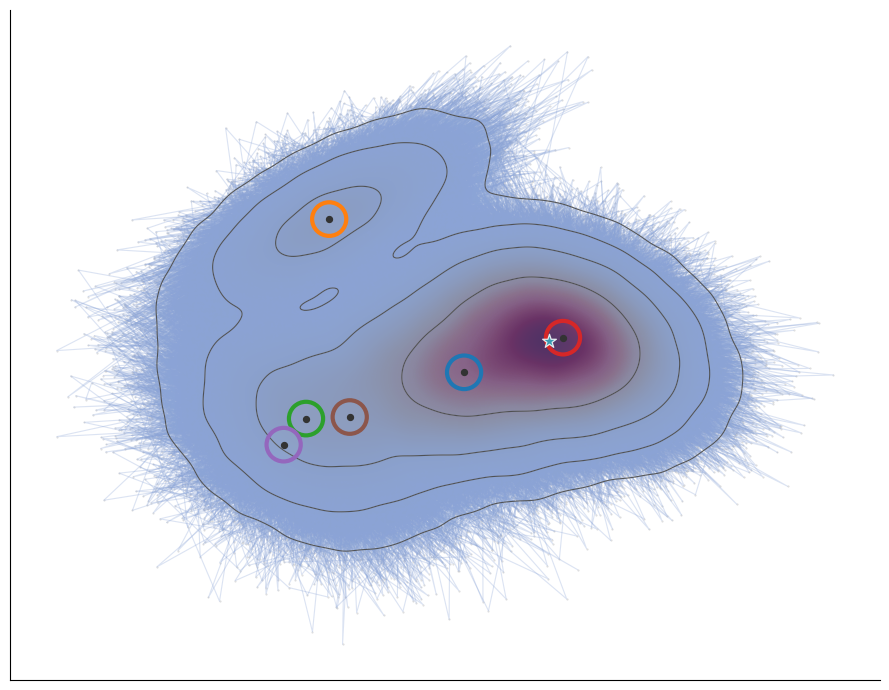

In [68]:
out_path_jpg='figures/surrogate_disc6_cov1_4.svg'
draw_emotion_panel(out_path_jpg, X2_disc, XX_disc, YY_disc, dens_disc, thr_disc, traj_lines_disc, C2_disc)

In [69]:
import math
from collections import Counter

def shannon_entropy(probabilities):
    entropy = 0.0
    for p in probabilities:
        if p > 0:  # 避免log(0)的情况
            entropy -= p * math.log2(p)
    return entropy

In [70]:
print(X_disc6_all.shape, scores_all.shape)
X_disc6_sum = np.sum(X_disc6_all, axis=1)
H_surr = np.zeros(X_disc6_all.shape[0])
for i in range(X_disc6_all.shape[0]):
    H_surr[i] = shannon_entropy(X_disc6_all[i,:] / X_disc6_sum[i])

scores_sum = np.sum(scores_all, axis=1)
H = np.zeros(scores_all.shape[0])
for i in range(scores_all.shape[0]):
    H[i] = shannon_entropy(scores_all[i,:] / scores_sum[i])

print('surrogate:', np.mean(H_surr), np.std(H_surr))
print('real:', np.mean(H), np.std(H))

(356168, 6) (356168, 6)
surrogate: 2.2268380220844333 0.2939281069298005
real: 2.262269142459807 0.26909072238618514


In [71]:
import scipy.stats as stats
stats.ttest_ind(H_surr, H)

TtestResult(statistic=np.float64(-53.06175654994931), pvalue=np.float64(0.0), df=np.float64(712334.0))

In [72]:
data_sort = np.sort(scores_all, axis=1)
data_sort_surr = np.sort(X_disc6_all, axis=1)
delta_sort = data_sort[:,-1] - data_sort[:,-2]
delta_sort_surr = data_sort_surr[:,-1] - data_sort_surr[:,-2]

print('surrogate:', np.mean(delta_sort_surr), np.std(delta_sort_surr))
print('real:', np.mean(delta_sort), np.std(delta_sort))

surrogate: 1.2693931156580764 0.796200381593341
real: 0.9908750598968276 0.7611913475941564


In [73]:
stats.ttest_ind(delta_sort_surr, delta_sort)

TtestResult(statistic=np.float64(150.89943969600924), pvalue=np.float64(0.0), df=np.float64(712334.0))

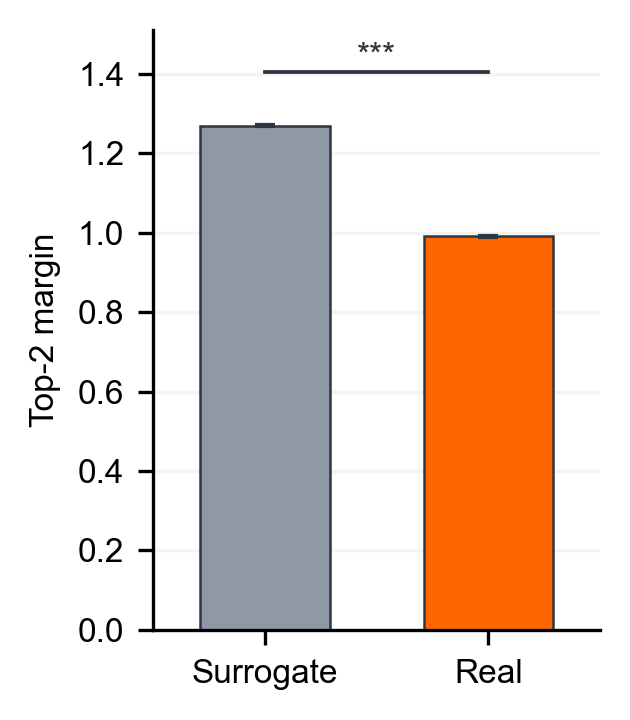

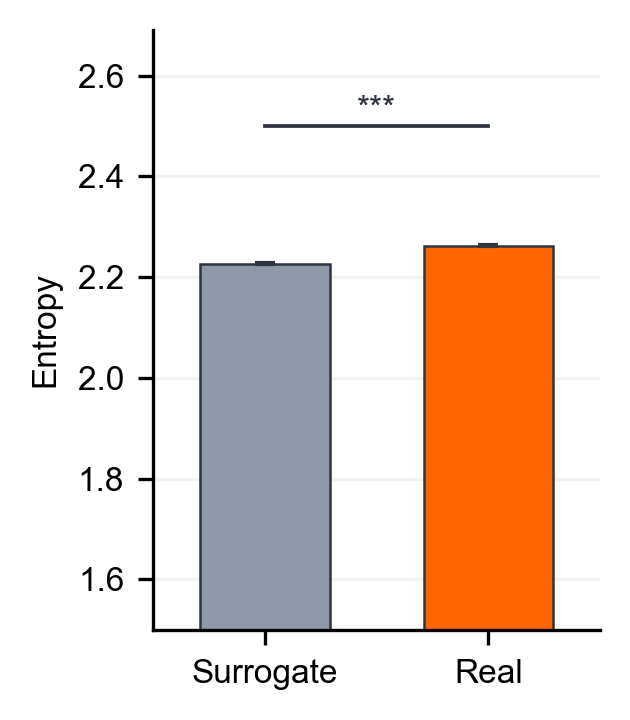

In [74]:
import numpy as np
import matplotlib.pyplot as plt

COLOR_SHUFFLED = "#8E98A7"
COLOR_REAL     = "#FF6600" #"#FF5500"
EDGE_COLOR     = "#2E3440"
SPINE_COLOR    = "#D1D5DB"

def _p_to_stars(p):
    if p < 1e-4: return "****"
    if p < 1e-3: return "***"
    if p < 1e-2: return "**"
    if p < 5e-2: return "*"
    return "n.s."

def _add_sig_bracket(ax, x1, x2, y, h=0.03, text="***", color=EDGE_COLOR, fs=8):
    ax.plot([x1, x2], [y+h, y+h],
            lw=0.9, c=color, clip_on=False)
    ax.text((x1+x2)/2, y+h, text, ha="center", va="bottom",
            fontsize=fs, color=color)

def plot_coocc_bar(ax, surr, real, use_sem=True, ylabel="Δ co-occurrence",
                   annotate_sig="auto", ylim_min=0):  # annotate_sig: "auto" | "***" | None
    means = np.array([np.mean(surr), np.mean(real)])
    if use_sem:
        errs  = np.array([np.std(surr, ddof=1)/np.sqrt(len(surr)),
                          np.std(real, ddof=1)/np.sqrt(len(real))])
        ylab_suffix = " (mean ± s.e.m.)"
    else:
        errs  = np.array([np.std(surr, ddof=1), np.std(real, ddof=1)])
        ylab_suffix = " (mean ± s.d.)"

    x = np.arange(2)
    ax.bar(x, means, width=0.58,
           color=[COLOR_SHUFFLED, COLOR_REAL],
           edgecolor=EDGE_COLOR, linewidth=0.6,
           yerr=errs, capsize=2.5,
           error_kw=dict(elinewidth=0.9, ecolor=EDGE_COLOR, capsize=2.5))

    ax.set_xticks(x)
    ax.set_xticklabels(["Surrogate", "Real"], fontsize=8)
    ax.set_ylabel(ylabel, fontsize=8)
    # ax.set_ylabel(ylabel + ylab_suffix, fontsize=8)
    ax.tick_params(axis="y", labelsize=8)
    ax.yaxis.grid(True, linestyle="-", alpha=0.15)
    ax.set_axisbelow(True)
    for side in ["top", "right"]:
        ax.spines[side].set_visible(False)
    # ax.spines["left"].set_color(SPINE_COLOR)
    # ax.spines["bottom"].set_color(SPINE_COLOR)
    ax.set_xlim(-0.5, 1.5)

    if annotate_sig is None:
        text = None
    elif annotate_sig == "auto":
        try:
            from scipy.stats import ttest_ind
            p = ttest_ind(real, surr, equal_var=False).pvalue
            text = _p_to_stars(p)
        except Exception:
            text = "***"  
    else:
        text = annotate_sig  

    if text is not None:
        ymax_bar = np.max(means + errs)
        ymin, ymax = ax.get_ylim()
        span = ymax - ymin if ymax > ymin else max(1.0, abs(ymax_bar))
        y = ymax_bar + 0.06 * span     
        h = 0.04 * span                
        _add_sig_bracket(ax, x[0], x[1], y, h=h, text=text, color=EDGE_COLOR, fs=8)
        ax.set_ylim([ylim_min, y + 0.12*span])  

fig, ax = plt.subplots(figsize=(2.2, 2.5), dpi=300)
plot_coocc_bar(ax, delta_sort_surr, delta_sort, use_sem=True, ylabel="Top-2 margin", annotate_sig='***')
plt.tight_layout()
plt.savefig('figures/dynamic_surrogate_test.svg')
plt.show()

fig, ax = plt.subplots(figsize=(2.2, 2.5), dpi=300)
plot_coocc_bar(ax, H_surr, H, use_sem=True, ylabel="Entropy", annotate_sig='***', ylim_min=1.5)
plt.tight_layout()
plt.savefig('figures/dynamic_surrogate_test_entropy.svg')
plt.show()

### Plot for argmax emotions

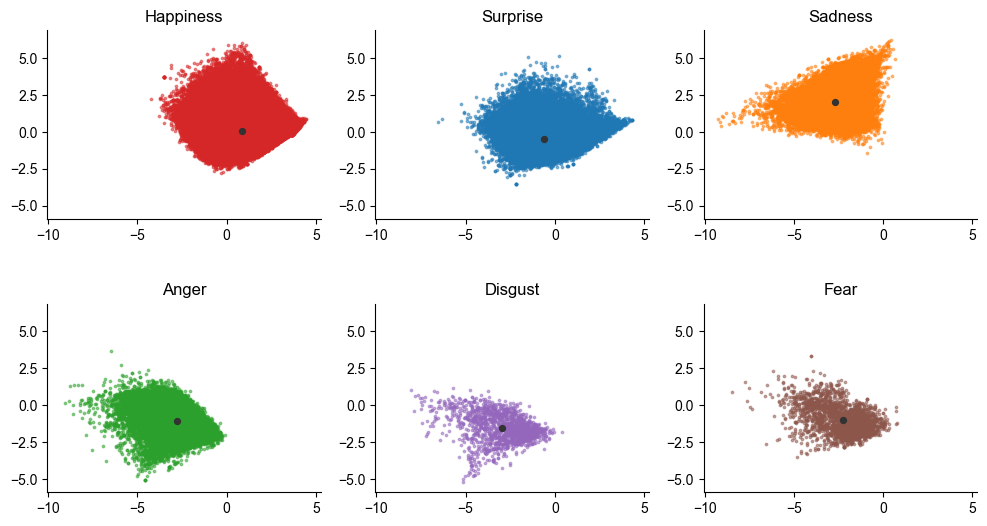

In [21]:
fig, axes = plt.subplots(
    2, 3,
    figsize=(12, 6),
    gridspec_kw={'hspace': 0.45}  # 这里直接控制两行之间的间距
)

for i, ax in enumerate(axes.flat):
    use_inds = np.where(np.argmax(scores_all, axis=1) == i)[0]
    ax.scatter(X2[use_inds, 0], X2[use_inds, 1], s=3, c=EMO_COLORS[i], alpha=0.5)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_title(EMO_NAMES[i])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    cx, cy = np.mean(X2[use_inds, 0]), np.mean(X2[use_inds, 1])
    ax.scatter([cx], [cy], s=18, color="#333333", zorder=4)
plt.show()